# Inferential Statistics III - Bayesian

## Medical charge data set

### Loading the data and performing an initial view

In [33]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
import seaborn as sns

In [34]:
medical = pd.read_csv('data/insurance2.csv')

In [35]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [36]:
insured = medical.charges[medical.insuranceclaim == 1]
uninsured = medical.charges[medical.insuranceclaim == 0]
n_insured = len(insured)
n_uninsured = len(uninsured)

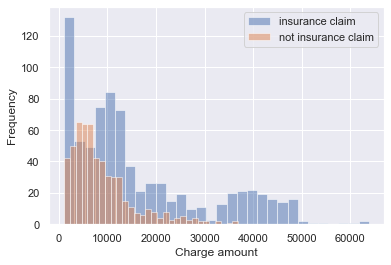

In [37]:
_ = plt.hist(insured, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(uninsured, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

### Initial parameter estimation

We'll try to model the uninsured patients' charges. Data with all positive values and this much right skew can be modelled well with a gamma distribution or a log-normal distribution. We'll try a gamma distribution, the less extremely skewed of the two. 

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made based on the mean and variance of the observed charges. The mean of a gamma distribution is $\alpha\beta$ and the variance is $\alpha\beta^2$, which allows us estimate the two parameter values using our observed $\mu$ and $\sigma^2$:

\begin{equation}
\frac{\mu^2}{\sigma^2} = \frac{(\alpha\beta)^2}{\alpha\beta^2} = \frac{\alpha^2\beta^2}{\alpha\beta^2} = \alpha
\end{equation}

\begin{equation}
\frac{\sigma^2}{\mu} = \frac{\alpha\beta^2}{\alpha\beta} = \beta
\end{equation}


In [38]:
alpha_est = np.mean(uninsured)**2 / np.var(uninsured)
beta_est = np.var(uninsured) / np.mean(uninsured)
alpha_est, beta_est

(1.8759059725250895, 4702.486170152818)

### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [39]:
seed(47)
uninsured_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_uninsured)

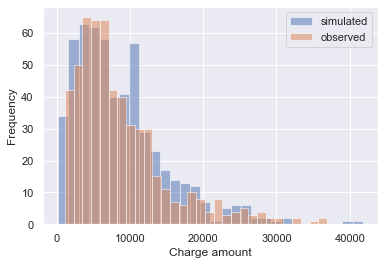

In [40]:
sns.set()
_ = plt.hist(uninsured_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(uninsured, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [41]:
# PyMC3 Gamma uses rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250895, 0.00021265346963636103)

__1:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data
6. Perform 10000 draws

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then before that you obviously need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__ We define the gamma distribution with its required stochastic variables `alpha` and `beta`.

In [42]:
with pm.Model() as model:
    # build the model
    alpha_ = pm.Exponential('alpha', 1/alpha_est)
    rate_ = pm.Exponential('rate', 1/rate_est)
    gamma_distribution = pm.Gamma("gamma", alpha_, rate_, observed=uninsured)
    
    # run the trace
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [rate]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:10<00:00, 2804.34draws/s]
The number of effective samples is smaller than 10% for some parameters.


__2:__ Explore your posteriors for $\alpha$ and $\beta$.

__A:__ $\alpha$'s histogram shows a normal distribution. This looks alright, as it suggests that this model parmaeter converged toward a value. A bad plot would look like an exponential distribution.

In [43]:
alpha_samples = trace['alpha']
rate_samples = trace['rate']

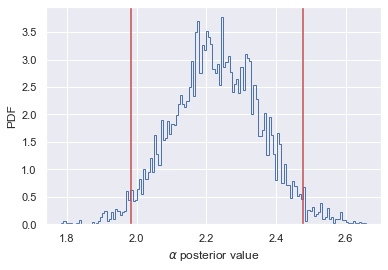

array([1.9849195 , 2.47768783])

In [44]:
interval = np.percentile(alpha_samples, [2.5, 97.5])
[plt.axvline(x, color='r') for x in interval]

plt.hist(alpha_samples, bins=int(np.sqrt(len(alpha_samples))), density=True, histtype='step')
plt.xlabel(r'$\alpha$ posterior value')
plt.ylabel('PDF')
plt.show()
interval

The 95\% credible interval for $\alpha$ is $1.98 \le x \le 2.48$, a bit north of our original estimate of 1.88.

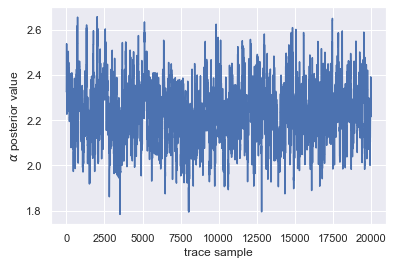

In [45]:
plt.plot(alpha_samples)
plt.xlabel('trace sample')
plt.ylabel(r'$\alpha$ posterior value')
plt.show()

The rate parameter also converged toward a value:

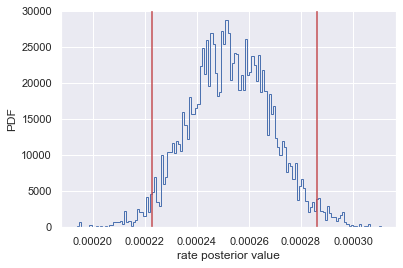

array([0.00022265, 0.00028601])

In [46]:
interval = np.percentile(rate_samples, [2.5, 97.5])
[plt.axvline(x, color='r') for x in interval]

plt.hist(rate_samples, bins=int(np.sqrt(len(rate_samples))), density=True, histtype='step')
plt.xlabel('rate posterior value')
plt.ylabel('PDF')
plt.show()
interval

The 95\% credible interval for the rate paramter is $.00022 \le x \le .00029$ As a reciprocal range, this is betweeen  3,496 and 4,491, a bit south of our initial estimate of 4,702.

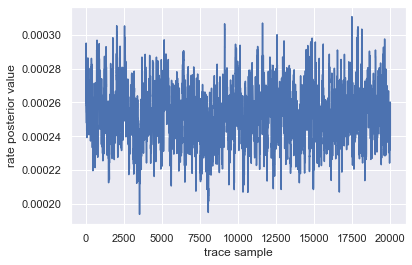

In [47]:
plt.plot(rate_samples)
plt.xlabel('trace sample')
plt.ylabel('rate posterior value')
plt.show()

__3:__ Play around with some of the built-in diagnostic plots for your model. I suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__ The diagnostic plots show some interesting differences between the trace's two chains but generally behave like those plotted above. It looks like the values converged more desirably in the second chain, as shown in the autocorrelation plot: we see both variables achieve a lower level of autocorrelation at the end of the chain. This explains the difference in standard deviation between the two chains' PDFs: a quicker convergence to a particular value represents values near the convergence value more often, leading to higher kurtosis.

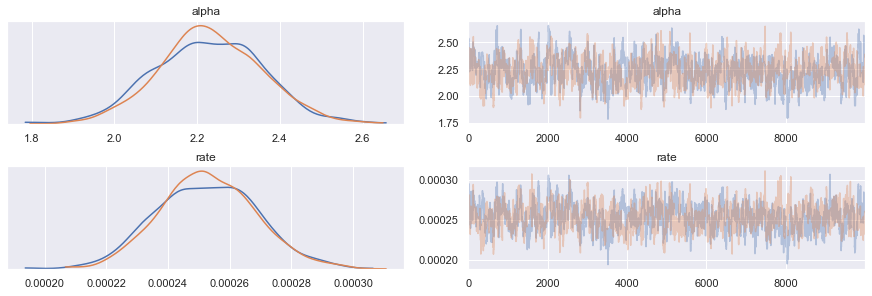

In [48]:
pm.plots.traceplot(trace, var_names=["alpha", "rate"])
plt.show()

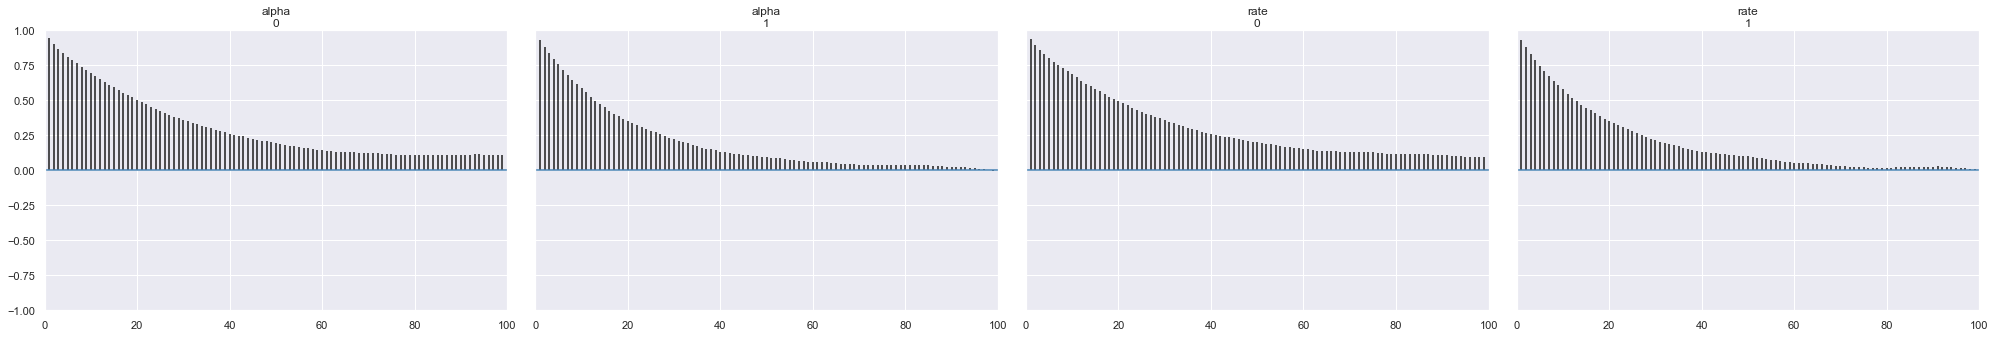

In [49]:
pm.plots.autocorrplot(trace, var_names=['alpha', 'rate'])
plt.show()

__4:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__

In [50]:
alpha = np.mean(alpha_samples)
beta = 1/np.mean(rate_samples)
simulated_data = gamma(alpha, scale=beta).rvs(n_uninsured)

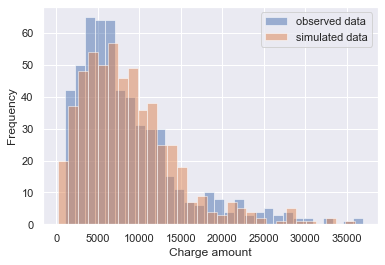

In [51]:
_ = plt.hist(uninsured, bins=30, alpha=0.5, label='observed data')
_ = plt.hist(simulated_data, bins=30, alpha=0.5, label='simulated data')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()